In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing lib**

In [2]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
import math
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Preprocessing** : Converting into lower case, applying lemmatization, removing stopwords and punctuation.


In [3]:
data=pd.read_excel('/content/drive/MyDrive/Annotated_Article_Dataset.xlsx')
data=data.dropna()

In [4]:
#Preprocessing the Dataset
def Preprocessing(text):

  #converting into lower case
  text=text.lower()

  #lemmatization
  lemmatizer = WordNetLemmatizer()
  tokens = nltk.word_tokenize(text)
  new_tokens=[] 
  #applying lemmatization
  for token in tokens:
    new_tokens.append(lemmatizer.lemmatize(token))

  #Removing stopwords and Punctuation
  stop = stopwords.words('english') + list(string.punctuation) + ["''","``",".."]
  preprocessed = " ".join(i for i in new_tokens if i not in stop)
  return preprocessed


In [5]:
def preprocess(raw_data):
  #articles
  articles=[]
  #label assigned to them
  labels=[]
  #Iterating through articles & label
  for article,label in zip(raw_data.Article.iloc,raw_data.Annotation.iloc):    
    article=Preprocessing(article)
    articles.append(article)  
    labels.append(label.upper())
  Tuples = list(zip(articles, labels))  
  return pd.DataFrame(Tuples, columns = ['Article', 'label']) 


**Preprocessed Dataset**

In [6]:
df=preprocess(data)

**Plotting the data labels** : BJP, Congress, AAP and None (Not biased)

Counter({'NONE': 334, 'BJP': 287, 'CONGRESS': 191, 'AAP': 87})


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


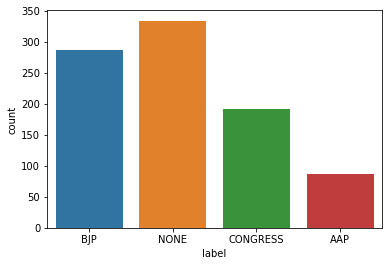

In [7]:
import seaborn as sns
def plot_count(Y_data):
  y=Counter(Y_data)
  print(y)
  sns.countplot(Y_data)

plot_count(df['label'])

**Splitting The DataSet**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report,accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(df['Article'],df['label'], test_size=0.25,random_state=42,shuffle=True,stratify=df['label'])

**BASELINE MODELS:**

**1. Naive Bayes without feature selection:**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Count Vectorizer
Count=CountVectorizer()
x_train=Count.fit_transform(X_train)
x_test=Count.transform(X_test)

#Tf-idf Transformer
tf_idf=TfidfTransformer()
x_train=tf_idf.fit_transform(x_train)
x_test=tf_idf.transform(x_test)

#Multinomial Naive Bayes
clf = MultinomialNB().fit(x_train, Y_train)
y_predicted = clf.predict(x_test)
print("F1 Score:")
print(f1_score(Y_test, y_predicted,average='weighted'))
print("Classification Report:")
print(classification_report(Y_test,y_predicted))
print("Accuracy:")
print(accuracy_score(Y_test,y_predicted)*100)

F1 Score:
0.586546921450363
Classification Report:
              precision    recall  f1-score   support

         AAP       0.00      0.00      0.00        22
         BJP       0.61      0.88      0.72        72
    CONGRESS       1.00      0.27      0.43        48
        NONE       0.64      0.83      0.72        83

    accuracy                           0.64       225
   macro avg       0.56      0.49      0.47       225
weighted avg       0.64      0.64      0.59       225

Accuracy:
64.44444444444444


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import pickle
filename = '/content/drive/MyDrive/IR PROJECT/NB_Without_FeatureSelection.sav'
pickle.dump(clf, open(filename, 'wb'))

**Feature Selection**

In [11]:
class_label={'BJP':0,'CONGRESS':1,'AAP':2,'NONE':3}
reverse_class_label={0:'BJP',1:'CONGRESS',2:'AAP',3:'NONE'} 
def table_creation(X_train,Y_train):
  #To keep the track of the Article Count of a term in a particular class
  # table dictionary will have class count for each term.
  table={}  
  #Term count in a class           
  term_count={}
  #Number of Articles in a Class         
  docs_count=np.array([0,0,0,0])
  #Number of Words in a Class
  words_count=np.array([0,0,0,0])
  class_count=np.array([0,0,0,0])

  for article,label in zip(X_train,Y_train):
    docs_count[class_label[label]]+=1
    words_count[class_label[label]]+=len(article)
    unique_Tokens={-1}
    for term in article.split():
      #term count in of each term in each class
      if term not in term_count:
        term_count[term]=class_count.copy()
      term_count[term][class_label[label]]+=1
      unique_Tokens.add(term)
    
    #print("unique tokens in article are",unique_Tokens)
    unique_Tokens.remove(-1) 

    for term in unique_Tokens:
      if term not in table:
        table[term]=class_count.copy()
      table[term][class_label[label]]+=1
  
  return table, words_count, docs_count, term_count
  
table, words_count, docs_count, term_count=table_creation(X_train,Y_train)

**Calculate Mutual Information**

In [12]:
#Calculating Mutual Information for each term in each Class: BJP, AAP, Congress, None(NOT BIASED)
def calculating_Mutual_Info(table,words_count,docs_count):
  N=0
  for i in docs_count:
    N+=i
  print("total number of articles are",N)
  #List to contain the mutual info for each class
  mutual_Info_table=[[],[],[],[]] 
  for term in table:
      for class_ in range(0,4):
          #Term Present in class
          N_11=table[term][class_]  
          #Term Present but not in Class
          N_10=np.sum(table[term])-N_11 
          #Num of Docs in class NOT having term       
          N_01=docs_count[class_]-N_11
          #Num of Docs neither Term Nor Class
          N_00=N-(N_01+N_10+N_11)                
          
          if N_11==0:
              X=0
          else:
              X=(N_11/N) * ((np.log(N)+np.log(N_11)) - (np.log(N_11+N_01) + np.log(N_11+N_10)))
          if N_01==0:
              Y=0
          else:
              Y=(N_01/N) * ((np.log(N)+np.log(N_01)) - (np.log(N_01+N_00) + np.log(N_01+N_11)))
          if N_10==0:
              Z=0
          else:
              Z=(N_10/N) * ((np.log(N)+np.log(N_10)) - (np.log(N_10+N_11) + np.log(N_10+N_00)))
          if N_00==0:
              W=0
          else:
              W=(N_00/N) * ((np.log(N)+np.log(N_00)) - (np.log(N_00+N_01) + np.log(N_00+N_10)))
          m=X+Y+Z+W
          mutual_Info_table[class_].append(m)
  return mutual_Info_table
mutual_Info_table=calculating_Mutual_Info(table,words_count, docs_count)


total number of articles are 674


In [13]:
#creating word map, each word is assigned a uniuqe id like we did for each document
def creating_map_of_words(list_of_words):
    forward_map={}
    reverse_map={}
    count=0
    for word in list_of_words:
        forward_map[word] = count
        count = count + 1
    reverse_map = {v: k for k, v in forward_map.items()}
    return forward_map,reverse_map
forward_map,reverse_map=creating_map_of_words(table.keys())


In [14]:
#this method will select feaures for each class and returns new vocabulary
def feature_selection(mutual_Info_table,k,forward_map,reverse_map):
    top_k_words=[]
    for id in range(0,4):
        temp = np.argsort(np.array(mutual_Info_table[id]))
        temp = temp[::-1]
        top_k_words.append(temp[:k].copy())
    
    new_vocab={-1}
    count=0
    for list_of_words in top_k_words:
        for wordid in list_of_words:
            new_vocab.add(reverse_map[wordid])
        count=count+1
        
    new_vocab.remove(-1)
    return top_k_words,new_vocab

top_k_words,new_vocab=feature_selection(mutual_Info_table,200,forward_map,reverse_map)


In [15]:
#to calculate term and class probability 
def calc_prob(new_vocab,term_count,class_word_count,docs_count):
    tprobability={}
    beta=len(new_vocab)
    for word in new_vocab:
      tprobability[word]=[]
      for id in range(0,4):
        tot=class_word_count[id]
        tc=term_count[word][id]
        p=(tc+1)/(tot+beta)
        tprobability[word].append(p)    
    cprobability=[]
    N=np.sum(docs_count)
    for doc_count in docs_count:
        cprobability.append(doc_count/N)
    return cprobability,tprobability
cprobability,tprobability=calc_prob(new_vocab,term_count,words_count,docs_count)

**2. Naive Bayes With Feature Selection:**

In [16]:
def naive_bayes(new_vocab,term_probability,class_probability,X_test):
    y_predicted=[]
    for article in X_test:
        max_score=-math.inf
        score=0
        result_class=-1                          
        for id in range(0,4):
            score=np.log(class_probability[id])
            for word in article.split():
                if word in new_vocab:
                    score=score+np.log(term_probability[word][id])
            if score>max_score:
                max_score=score
                result_class=id
        y_predicted.append(reverse_class_label[result_class])       
    return y_predicted          

y_predicted=naive_bayes(new_vocab,tprobability,cprobability,X_test)


In [17]:
print('Confusion Matrix :')
print(confusion_matrix(Y_test, y_predicted)) 
print('Accuracy Score :',accuracy_score(Y_test, y_predicted)*100 )
print('Classification Report : ')
print(classification_report(Y_test, y_predicted) )

Confusion Matrix :
[[22  0  0  0]
 [ 3 58 10  1]
 [ 1  7 40  0]
 [11  9  5 58]]
Accuracy Score : 79.11111111111111
Classification Report : 
              precision    recall  f1-score   support

         AAP       0.59      1.00      0.75        22
         BJP       0.78      0.81      0.79        72
    CONGRESS       0.73      0.83      0.78        48
        NONE       0.98      0.70      0.82        83

    accuracy                           0.79       225
   macro avg       0.77      0.83      0.78       225
weighted avg       0.83      0.79      0.79       225



In [18]:
# filename = '/content/drive/MyDrive/IR PROJECT/NB_With_FeatureSelection.sav'
# pickle.dump(clf, open(filename, 'wb'))

**SVM without feature selection:**

**3. For Unigrams**

In [19]:
# SVM without feature Selection using different approaches:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC 

#tf idf vectorizer
vector=TfidfVectorizer(analyzer='word',ngram_range=(1,1))

x_train=vector.fit_transform(X_train)
x_test=vector.transform(X_test)

clf=SVC(verbose=True)
clf.fit(x_train,Y_train)
y_predicted=clf.predict(x_test)
print("F1 Score:")
print(f1_score(Y_test,y_predicted,average='weighted'))
print("Classificatin Report:")
print(classification_report(Y_test,y_predicted))
print("Accuracy:")
print(accuracy_score(Y_test,y_predicted)*100)

[LibSVM]F1 Score:
0.7581906958030066
Classificatin Report:
              precision    recall  f1-score   support

         AAP       1.00      0.77      0.87        22
         BJP       0.69      0.86      0.77        72
    CONGRESS       0.74      0.48      0.58        48
        NONE       0.80      0.84      0.82        83

    accuracy                           0.76       225
   macro avg       0.81      0.74      0.76       225
weighted avg       0.77      0.76      0.76       225

Accuracy:
76.44444444444444


In [20]:
filename = '/content/drive/MyDrive/IR PROJECT/SVM_Unigrams.sav'
pickle.dump(clf, open(filename, 'wb'))

**4. For Bigrams**

In [21]:
vector=TfidfVectorizer(analyzer='word',ngram_range=(2,2))
x_train=vector.fit_transform(X_train)
x_test=vector.transform(X_test)
clf=SVC(verbose=True)
clf.fit(x_train,Y_train)
y_predicted=clf.predict(x_test)
print("F1 Score:")
print(f1_score(Y_test,y_predicted,average='weighted'))
print("Classificatin Report:")
print(classification_report(Y_test,y_predicted))
print("Accuracy:")
print(accuracy_score(Y_test,y_predicted)*100)

[LibSVM]F1 Score:
0.40810643609627506
Classificatin Report:
              precision    recall  f1-score   support

         AAP       1.00      0.05      0.09        22
         BJP       0.73      0.38      0.50        72
    CONGRESS       0.50      0.04      0.08        48
        NONE       0.44      0.98      0.61        83

    accuracy                           0.49       225
   macro avg       0.67      0.36      0.32       225
weighted avg       0.60      0.49      0.41       225

Accuracy:
49.333333333333336


In [22]:
filename = '/content/drive/MyDrive/IR PROJECT/SVM_Bigrams.sav'
pickle.dump(clf, open(filename, 'wb'))

**5. SVM with Feature Selection**

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer
def count_vector(X_data,vocab,term_count):
  data_count=[]
  for index in X_data:
    count_vector=[]
    values=index.split(' ')
    for word in vocab:
      if word in values:
        count_vector.append(values.count(word))
      else:
        count_vector.append(0)
    data_count.append(count_vector)
  return data_count

In [24]:
x_train=count_vector(X_train,new_vocab,term_count)
x_test=count_vector(X_test,new_vocab,term_count)

In [25]:
vector=TfidfTransformer()
x_train=vector.fit_transform(x_train)
x_test=vector.transform(x_test)
clf=SVC(verbose=True)
clf.fit(x_train,Y_train)
y_predicted=clf.predict(x_test)
print("F1 Score:")
print(f1_score(Y_test,y_predicted,average='weighted'))
print("Classificatin Report:")
print(classification_report(Y_test,y_predicted))
print("Accuracy:")
print(accuracy_score(Y_test,y_predicted)*100)

[LibSVM]F1 Score:
0.8626810975235463
Classificatin Report:
              precision    recall  f1-score   support

         AAP       0.96      1.00      0.98        22
         BJP       0.76      0.90      0.82        72
    CONGRESS       0.88      0.73      0.80        48
        NONE       0.95      0.87      0.91        83

    accuracy                           0.86       225
   macro avg       0.88      0.87      0.88       225
weighted avg       0.87      0.86      0.86       225

Accuracy:
86.22222222222223


In [26]:
filename = '/content/drive/MyDrive/IR PROJECT/SVM_With_FeatureSelection.sav'
pickle.dump(clf, open(filename, 'wb'))